In [ ]:
# Installation des librairies nécessaires
!pip install pandas seaborn matplotlib geopandas mapclassify --quiet

# Importation des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from google.colab import drive


# Configuration du style graphique
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6) # Agrandir les figures par défaut

In [ ]:
# Définition du chemin vers le dossier (À adapter selon ton Drive)
chemin_dossier = '/content/drive/MyDrive/1.Archive/'

# Liste pour stocker les dataframes temporaires
liste_dfs = []

print("Début du chargement des fichiers...")

# On parcourt tous les fichiers du dossier
files = os.listdir(chemin_dossier)

for fichier in files:
    if fichier.endswith('.csv'):
        # On récupère le chemin complet
        chemin_complet = os.path.join(chemin_dossier, fichier)

        try:
            # Lecture du CSV
            df_temp = pd.read_csv(chemin_complet)

            # On essaye de deviner la ville et le type (semaine/weekend) avec le nom du fichier
            # Exemple: "london_weekdays.csv" -> Ville = London
            nom_propre = fichier.replace('.csv', '')
            parties = nom_propre.split('_')

            ville = parties[0].capitalize() # Met la première lettre en majuscule
            type_jour = parties[1]          # weekdays ou weekends

            # On ajoute ces infos dans le tableau
            df_temp['Ville'] = ville
            df_temp['Type_Jour'] = type_jour

            # On nettoie la colonne bizarre 'Unnamed: 0' si elle existe
            if 'Unnamed: 0' in df_temp.columns:
                df_temp = df_temp.drop(columns=['Unnamed: 0'])

            # On ajoute à la liste
            liste_dfs.append(df_temp)
            print(f"-> Fichier chargé : {fichier} ({len(df_temp)} lignes)")

        except Exception as e:
            print(f"Erreur sur le fichier {fichier} : {e}")

# Fusion de tous les tableaux en un seul
df_complet = pd.concat(liste_dfs, ignore_index=True)

# Vérification rapide
print("-" * 30)
print(f"Terminé ! Total de lignes : {len(df_complet)}")
df_complet.head()

Début du chargement des fichiers...
-> Fichier chargé : amsterdam_weekdays.csv (1103 lignes)
-> Fichier chargé : amsterdam_weekends.csv (977 lignes)
-> Fichier chargé : barcelona_weekdays.csv (1555 lignes)
-> Fichier chargé : athens_weekdays.csv (2653 lignes)
-> Fichier chargé : athens_weekends.csv (2627 lignes)
-> Fichier chargé : barcelona_weekends.csv (1278 lignes)
-> Fichier chargé : berlin_weekdays.csv (1284 lignes)
-> Fichier chargé : berlin_weekends.csv (1200 lignes)
-> Fichier chargé : budapest_weekdays.csv (2074 lignes)
-> Fichier chargé : budapest_weekends.csv (1948 lignes)
-> Fichier chargé : lisbon_weekends.csv (2906 lignes)
-> Fichier chargé : paris_weekdays.csv (3130 lignes)
-> Fichier chargé : london_weekends.csv (5379 lignes)
-> Fichier chargé : lisbon_weekdays.csv (2857 lignes)
-> Fichier chargé : paris_weekends.csv (3558 lignes)
-> Fichier chargé : london_weekdays.csv (4614 lignes)
-> Fichier chargé : rome_weekends.csv (4535 lignes)
-> Fichier chargé : vienna_weekends

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Ville,Type_Jour
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekdays


In [ ]:
# 1. Suppression des doublons
df_clean = df_complet.drop_duplicates()
print(f"Doublons supprimés. Lignes restantes : {len(df_clean)}")

# 2. Gestion des prix aberrants
# On remarque que certains prix sont énormes (> 1000€), on va les filtrer pour y voir plus clair
df_clean = df_clean[df_clean['realSum'] < 800]

# 3. Création de nouvelles colonnes
# Prix par personne
df_clean['Prix_Par_Pers'] = df_clean['realSum'] / df_clean['person_capacity']

# On catégorise la distance pour faire des groupes
# Si dist < 2km -> Centre, sinon Banlieue
def categoriser_distance(d):
    if d < 2:
        return "Hyper-Centre"
    elif d < 5:
        return "Centre"
    elif d < 10:
        return "Périphérie"
    else:
        return "Loin"

# On applique la fonction sur la colonne 'dist'
df_clean['Zone'] = df_clean['dist'].apply(categoriser_distance)

# Aperçu des stats de base
df_clean.describe()

Doublons supprimés. Lignes restantes : 51707


,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,Prix_Par_Pers
count,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000,50211.000000
mean,248.064033,3.125490,0.293501,0.348569,9.388998,92.601741,1.135170,3.206180,0.687647,289.557969,13.056726,620.093740,22.523080,7.569898,45.541549,87.015609
std,142.373002,1.279737,0.455371,0.476522,0.953887,8.920505,0.606077,2.406108,0.866793,222.495241,9.347257,495.858780,17.660527,9.886216,5.243056,52.250907
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.034661,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,8.851498
25%,147.165655,2.000000,0.000000,0.000000,9.000000,90.000000,1.000000,1.462282,0.249612,134.241340,6.274563,246.177208,8.614534,-0.070800,41.392975,50.994031
50%,207.559077,3.000000,0.000000,0.000000,10.000000,95.000000,1.000000,2.623405,0.415784,229.967266,11.251145,515.255325,17.369436,4.889700,47.502010,73.761485
75%,304.789209,4.000000,1.000000,1.000000,10.000000,98.000000,1.000000,4.274909,0.745016,378.811898,17.022071,825.249935,32.589725,16.316940,51.458860,109.480468
max,799.877702,6.000000,1.000000,1.000000,10.000000,100.000000,10.000000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410,399.850871


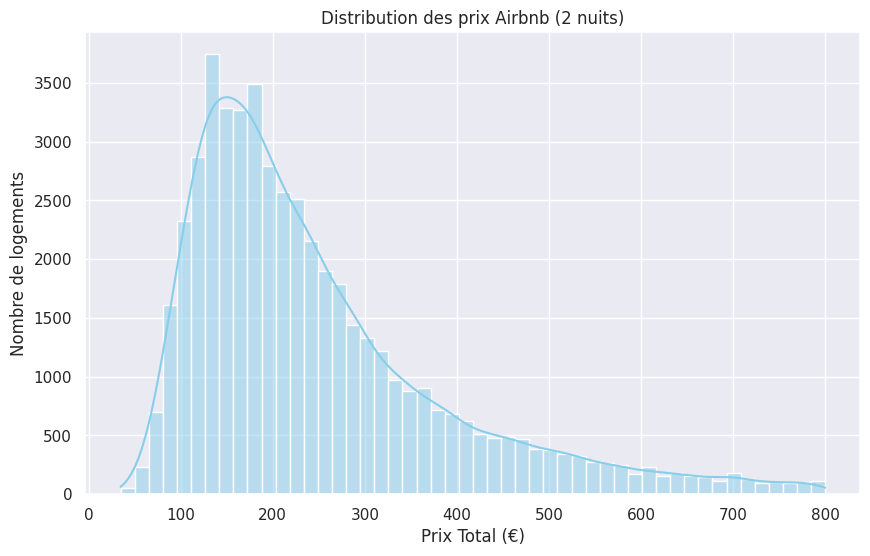

/tmp/ipython-input-1908085139.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clean, x='Ville', y='realSum', order=ordre, palette='viridis')


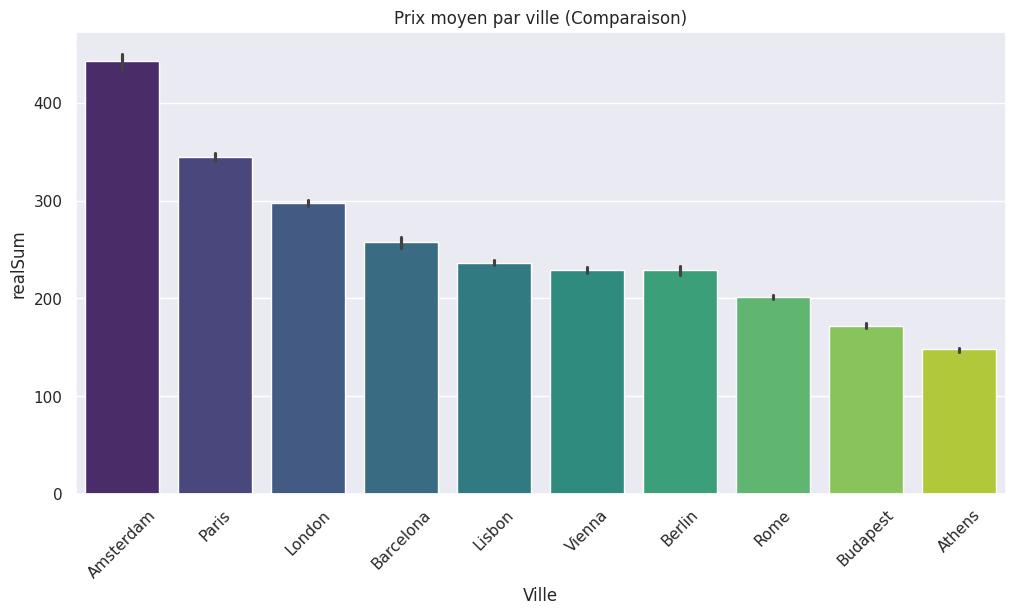

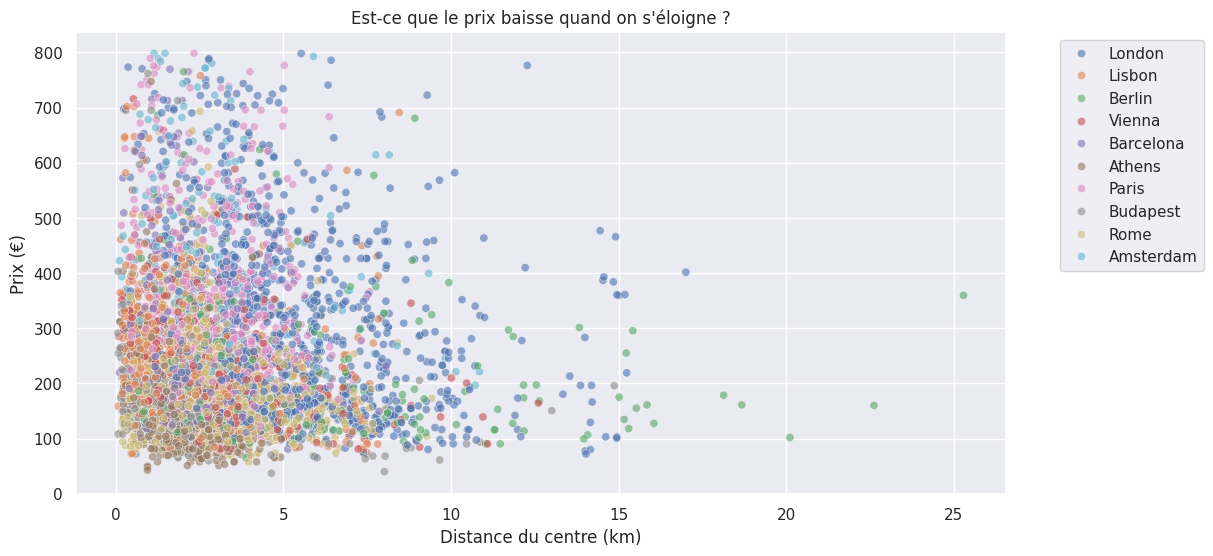

/tmp/ipython-input-1908085139.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='host_is_superhost', y='guest_satisfaction_overall', palette='Set2')


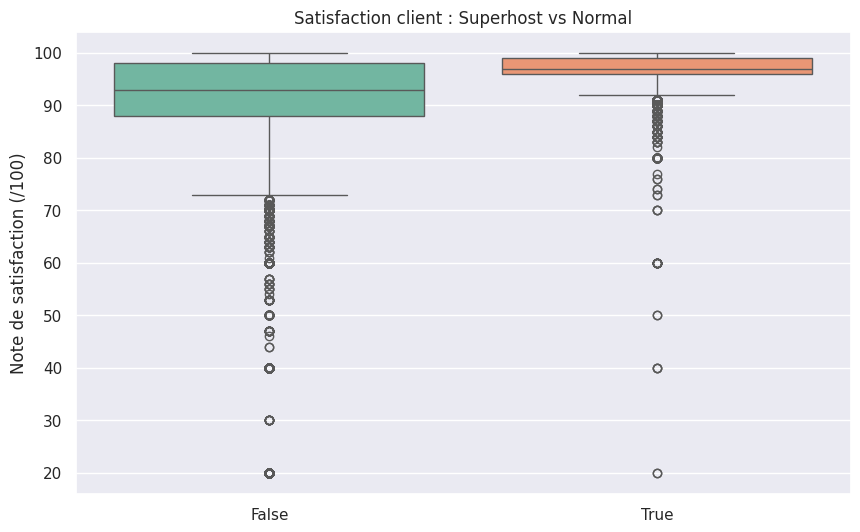

In [8]:
# GRAPHIQUE 1 : Histogramme des prix
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='realSum', bins=50, kde=True, color='skyblue')
plt.title('Distribution des prix Airbnb (2 nuits)')
plt.xlabel('Prix Total (€)')
plt.ylabel('Nombre de logements')
plt.show()

# GRAPHIQUE 2 : Prix moyen par Ville
plt.figure(figsize=(12, 6))
# On trie pour que ce soit plus joli
ordre = df_clean.groupby('Ville')['realSum'].mean().sort_values(ascending=False).index
sns.barplot(data=df_clean, x='Ville', y='realSum', order=ordre, palette='viridis')
plt.title('Prix moyen par ville (Comparaison)')
plt.xticks(rotation=45) # Penche les noms pour lire
plt.show()

# GRAPHIQUE 3 : Relation Prix vs Distance
plt.figure(figsize=(12, 6))
# On utilise 'sample' pour ne pas afficher 40 000 points
sns.scatterplot(data=df_clean.sample(5000), x='dist', y='realSum', hue='Ville', alpha=0.6)
plt.title('Est-ce que le prix baisse quand on s\'éloigne ?')
plt.xlabel('Distance du centre (km)')
plt.ylabel('Prix (€)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# GRAPHIQUE 4 : Impact des Superhosts
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='host_is_superhost', y='guest_satisfaction_overall', palette='Set2')
plt.title('Satisfaction client : Superhost vs Normal')
plt.xlabel('')
plt.ylabel('Note de satisfaction (/100)')
plt.show()

In [7]:
print("--- CALCUL DES INSIGHTS ---")

# 1. Ville la plus chère
moyennes = df_clean.groupby('Ville')['realSum'].mean()
ville_chere = moyennes.idxmax()
prix_max = moyennes.max()
print(f"1. La ville la plus chère est {ville_chere} avec {prix_max:.2f}€ en moyenne.")

# 2. Corrélation Prix / Distance
corr_dist = df_clean['realSum'].corr(df_clean['dist'])
print(f"2. Corrélation Prix vs Distance : {corr_dist:.3f}")
if corr_dist < 0:
    print("   -> (C'est négatif : plus on s'éloigne, plus le prix baisse)")

# 3. Superhost vs Prix
prix_super = df_clean[df_clean['host_is_superhost'] == True]['realSum'].mean()
prix_normal = df_clean[df_clean['host_is_superhost'] == False]['realSum'].mean()
diff = prix_super - prix_normal
print(f"3. Prix moyen Superhost : {prix_super:.2f}€ vs Normal : {prix_normal:.2f}€")
print(f"   -> Différence : {diff:.2f}€")

# 4. Impact de la Propreté sur la note globale
matrice_corr = df_clean[['guest_satisfaction_overall', 'cleanliness_rating', 'realSum']].corr()
print("\nMatrice de corrélation simplifiée :")
print(matrice_corr)

--- CALCUL DES INSIGHTS ---
1. La ville la plus chère est Amsterdam avec 442.33€ en moyenne.
2. Corrélation Prix vs Distance : -0.064
   -> (C'est négatif : plus on s'éloigne, plus le prix baisse)
3. Prix moyen Superhost : 229.47€ vs Normal : 254.52€
   -> Différence : -25.04€

Matrice de corrélation simplifiée :
                            guest_satisfaction_overall  cleanliness_rating  \
guest_satisfaction_overall                    1.000000            0.714892   
cleanliness_rating                            0.714892            1.000000   
realSum                                      -0.034464           -0.019295   

                             realSum  
guest_satisfaction_overall -0.034464  
cleanliness_rating         -0.019295  
realSum                     1.000000  
